In [1]:
# Install library for reading JPK File
# %pip uninstall pyafmreader --yes
# %pip install git+https://github.com/jlopezalo/pyafmreader.git

In [2]:
# Install library for AFM data Rheology Analysis
%pip uninstall pyafmrheo --yes
%pip install git+https://github.com/jlopezalo/pyafmrheo.git

Found existing installation: pyafmrheo 0.0.1
Uninstalling pyafmrheo-0.0.1:
  Successfully uninstalled pyafmrheo-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmrheo.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-q_w_vlrr
  Running command git clone -q https://github.com/jlopezalo/pyafmrheo.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-q_w_vlrr
  Created wheel for pyafmrheo: filename=pyafmrheo-0.0.1-py3-none-any.whl size=30919 sha256=41621738d95e193bb27a9ed446f848aaa96df39b6138a4b2b60a7127cad0d984
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-x7hyqc1z/wheels/45/a3/5e/2d19803e3cbf5fe45f904090127b31ec30fc304c6b6e5e0f70
Successfully built pyafmrheo
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to

In [3]:
# Import libraries we will need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend

# Get file reader from librar
from pyafmreader import loadfile

# Get data analysis tools
from pyafmrheo.utils.force_curves import *
from pyafmrheo.utils.signal_processing import *
from pyafmrheo.models.hertz import HertzModel
from pyafmrheo.models.rheology import ComputeBh

In [4]:
# Define global variables
file_path = '/Users/javierlopez/Documents/Datasets/29102021/Viscous Drag Correction - H20/Pos1/force-save-2021.10.29-16.43.34.600.jpk-force'
# If None it will use the deflection sensitivity from the file
deflection_sensitivity = None # m/V
# If None it will use the spring constant from the file
spring_constant = None # N/m
# General plotting params
plt.rcParams["figure.figsize"] = (10,5)

In [5]:
file = loadfile(file_path)

In [6]:
file_metadata = file.filemetadata

In [7]:
closed_loop = file_metadata['z_closed_loop']
file_deflection_sensitivity = file_metadata['defl_sens_nmbyV'] #nm/V
file_spring_constant = file_metadata['spring_const_Nbym'] #N/m
height_channel = file_metadata['height_channel_key']

if not deflection_sensitivity: deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
if not spring_constant: spring_constant = file_spring_constant

In [8]:
curve_idx = 0
force_curve = file.getcurve(curve_idx)
extend_segments = force_curve.extend_segments
pause_segments = force_curve.pause_segments
modulation_segments = force_curve.modulation_segments
retract_segments = force_curve.retract_segments
force_curve_segments = force_curve.get_segments()

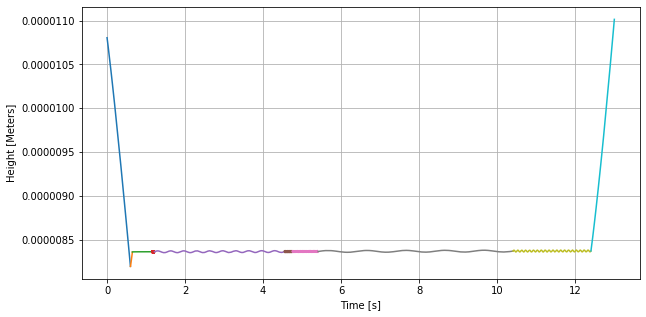

In [9]:
t0 = 0
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, height)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Height [Meters]")
plt.grid()
plt.show()

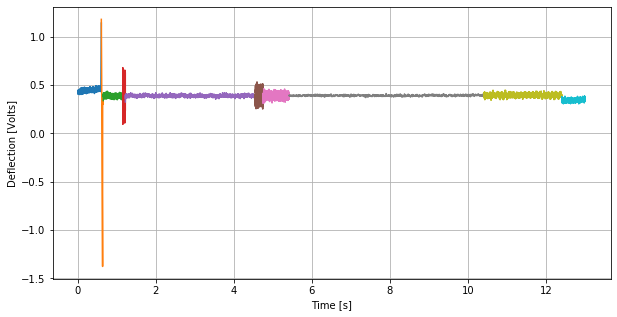

In [10]:
t0 = 0
for seg_id, segment in force_curve_segments:
    deflection = segment.segment_formated_data["vDeflection"]
    time = segment.segment_formated_data["time"] + t0
    plt.plot(time, deflection)
    t0 = time[-1]

plt.xlabel("Time [s]")
plt.ylabel("Deflection [Volts]")
plt.grid()
plt.show()

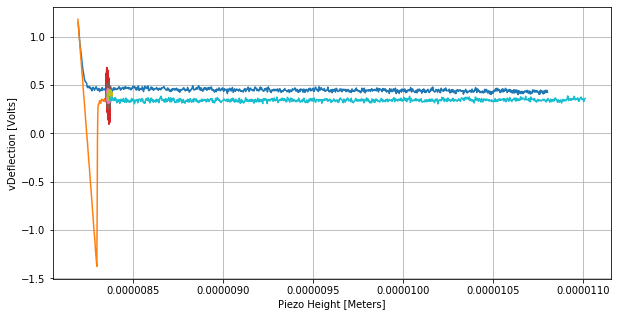

In [11]:
for seg_id, segment in force_curve_segments:
    height = segment.segment_formated_data[height_channel]
    deflection = segment.segment_formated_data["vDeflection"]
    plt.plot(height, deflection)

plt.xlabel("Piezo Height [Meters]")
plt.ylabel("vDeflection [Volts]")
plt.grid()
plt.show()

In [12]:
# Get distance from the sample, needed to compute Bh
first_ret_seg_id, first_ret_seg = retract_segments[0]
distance_from_sample = -1 * first_ret_seg.segment_metadata['ramp_size'] # Negative
print(f"Distance from sample {distance_from_sample * 1e-9} m")

Distance from sample 2.5000000000000004e-07 m


In [13]:
# Get approach, first extend segment
first_exted_seg_id, first_ext_seg = extend_segments[0]
first_ext_seg.preprocess_segment(deflection_sensitivity, height_channel)

# Get retract, last retract segment
last_ret_seg_id, last_ret_seg = retract_segments[-1]
last_ret_seg.preprocess_segment(deflection_sensitivity, height_channel)

if pause_segments:
    # Get first pause segment
    first_pause_seg_id, first_pause_seg = pause_segments[0]
    first_pause_seg.preprocess_segment(deflection_sensitivity, height_channel)

if modulation_segments:
    for seg_id, mod_seg in modulation_segments:
        mod_seg.preprocess_segment(deflection_sensitivity, height_channel)

In [14]:
# Shift height
xzero = last_ret_seg.zheight[-1] # Maximum height
first_ext_seg.zheight = xzero - first_ext_seg.zheight
last_ret_seg.zheight = xzero - last_ret_seg.zheight
if pause_segments:
    first_pause_seg.zheight = xzero - first_pause_seg.zheight
if modulation_segments:
    for seg_id, mod_seg in modulation_segments:
        mod_seg.zheight = xzero - mod_seg.zheight

In [15]:
poc = [0, 0]
if modulation_segments:
    for seg_id, mod_seg in modulation_segments:
        mod_seg.get_force_vs_indentation(poc, spring_constant)

In [16]:
help(ComputeBh)

Help on function ComputeBh in module pyafmrheo.models.rheology:

ComputeBh(deflection, zheight, poc, k, fs, freq, fi=0, amp_quotient=1, nfft=None, freq_tol=0.0001)



In [17]:
results = []

for seg_id, mod_seg in modulation_segments:
    frequency = mod_seg.segment_metadata["frequency"]
    time = mod_seg.time
    indentation = mod_seg.indentation
    force = mod_seg.force
    deltat = time[1] - time[0]
    fs = 1 / deltat
    ntra_in, ntra_out, ntra_time =\
        detrend_rolling_average(frequency, indentation, force, time, 'indentation', 'force', [])
    Bh, Hd, gamma2 = ComputeBh(ntra_out, ntra_in, poc, spring_constant, fs, frequency)
    results.append((frequency, Bh, Hd, gamma2))

results = sorted(results, key=lambda x: int(x[0]))
frequencies_results = [x[0] for x in results]
Bh_results = [x[1] for x in results]
Hd_results = [x[2] for x in results]

The frequency found at index 299.66703662597115 does not match with the frequency applied 300.0
The frequency found at index 2.99625468164794 does not match with the frequency applied 3.0
The frequency found at index 99.94447529150472 does not match with the frequency applied 100.0
The frequency found at index 29.983342587451418 does not match with the frequency applied 30.0
The frequency found at index 0.9966777408637872 does not match with the frequency applied 1.0
The frequency found at index 9.994447529150474 does not match with the frequency applied 10.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/spectral.py:1816: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


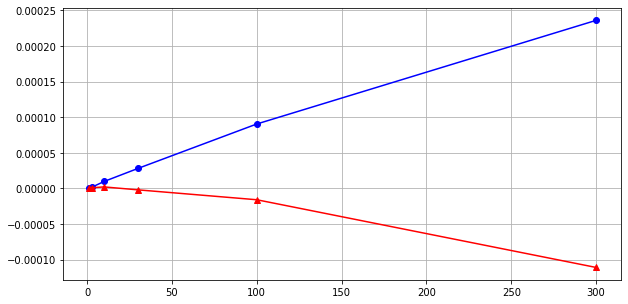

In [18]:
plt.plot(frequencies_results, np.imag(Hd_results), "bo-")
plt.plot(frequencies_results, np.real(Hd_results), "r^-")
plt.grid()
plt.show()

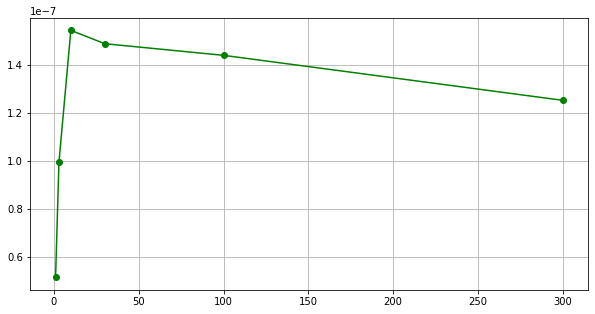

In [19]:
plt.plot(frequencies_results, Bh_results, "go-")
plt.grid()
plt.show()